# MGRG: Metric-Guided Region Growing con Semillas Inteligentes

Este notebook demuestra la implementación del algoritmo MGRG usando embeddings semánticos de Prithvi y semillas generadas por K-Means clustering.

## Objetivos
- Implementar MGRG con BFS sobre embeddings
- Comparar grid fijo vs K-Means inteligente
- Analizar resultados cuantitativamente

## Autor
- **Arthur Zizumbo** - Lead Developer

## Fecha
Noviembre 2025

## 1. Configuración Inicial e Imports

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from src.algorithms.semantic_region_growing import SemanticRegionGrowing
from src.features.hls_processor import load_embeddings, visualize_embeddings_pca

print("Setup completed successfully")

Setup completed successfully


## 2. Carga de Embeddings

Cargamos los embeddings generados en US-006 para las 3 zonas de México:
- **Mexicali**: Agricultura intensiva
- **Bajío**: Agricultura diversa  
- **Sinaloa**: Agricultura tecnificada

In [3]:
embeddings_dir = Path('../../img/sentinel2/embeddings')

zones = {
    'mexicali': 'mexicali_20251010.npz',
    'bajio': 'bajio_20251010.npz',
    'sinaloa': 'sinaloa_20251010.npz'
}

embeddings_data = {}

for zone_name, filename in zones.items():
    filepath = embeddings_dir / filename
    if filepath.exists():
        embeddings, metadata = load_embeddings(filepath)
        embeddings_data[zone_name] = {
            'embeddings': embeddings,
            'metadata': metadata
        }
        print(f"{zone_name.capitalize()}: {embeddings.shape}")
    else:
        print(f"Warning: {filepath} not found")

if len(embeddings_data) == 0:
    print("\nNo embeddings found. Creating synthetic embeddings for demo...")
    np.random.seed(42)
    embeddings_demo = np.random.rand(256, 256, 256)
    embeddings_demo = embeddings_demo / np.linalg.norm(embeddings_demo, axis=2, keepdims=True)
    embeddings_data['demo'] = {
        'embeddings': embeddings_demo,
        'metadata': {'zone': 'demo', 'synthetic': True}
    }
    print(f"Demo: {embeddings_demo.shape}")

Mexicali: (1124, 922, 256)
Bajio: (1092, 1057, 256)
Sinaloa: (1090, 1031, 256)


## 3. Generación de Semillas

### 3.1 Grid Fijo (Baseline)

Método tradicional que crea una cuadrícula regular de semillas.

In [4]:
zone_name = list(embeddings_data.keys())[0]
embeddings_test = embeddings_data[zone_name]['embeddings']

print(f"Using zone: {zone_name}")
print(f"Embeddings shape: {embeddings_test.shape}")

mgrg_grid = SemanticRegionGrowing(use_smart_seeds=False, random_state=42)
grid_seeds = mgrg_grid.generate_grid_seeds(embeddings_test, grid_size=20)

print(f"\nGrid seeds generated: {len(grid_seeds)}")

Using zone: mexicali
Embeddings shape: (1124, 922, 256)

Grid seeds generated: 2576


### 3.2 K-Means Inteligente (Innovación)

Método innovador que usa K-Means para encontrar semillas semánticamente representativas.

In [5]:
mgrg_kmeans = SemanticRegionGrowing(
    use_smart_seeds=True,
    n_clusters=5,
    random_state=42
)

smart_seeds = mgrg_kmeans.generate_smart_seeds(embeddings_test)

print(f"Smart seeds generated: {len(smart_seeds)}")
print(f"Reduction: {100 * (1 - len(smart_seeds)/len(grid_seeds)):.1f}%")

Smart seeds generated: 5
Reduction: 99.8%


### 3.3 Visualización de Semillas

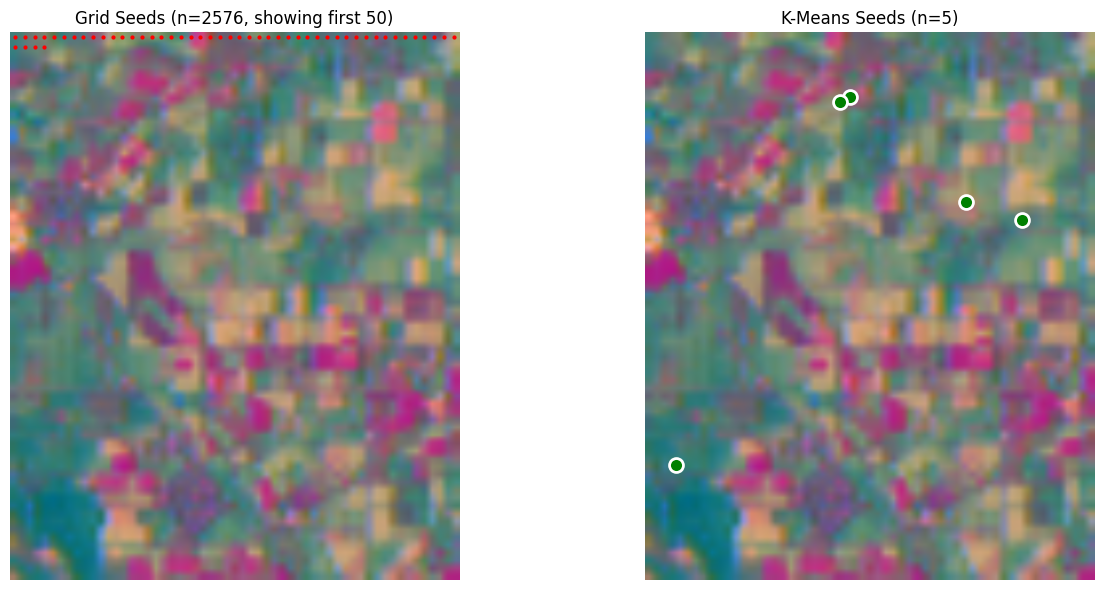

In [6]:
embeddings_rgb = visualize_embeddings_pca(embeddings_test, n_components=3)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(embeddings_rgb)
grid_seeds_sample = grid_seeds[:50] if len(grid_seeds) > 50 else grid_seeds
for y, x in grid_seeds_sample:
    axes[0].plot(x, y, 'ro', markersize=2)
axes[0].set_title(f'Grid Seeds (n={len(grid_seeds)}, showing first 50)')
axes[0].axis('off')

axes[1].imshow(embeddings_rgb)
for y, x in smart_seeds:
    axes[1].plot(x, y, 'go', markersize=10, markeredgecolor='white', markeredgewidth=2)
axes[1].set_title(f'K-Means Seeds (n={len(smart_seeds)})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Segmentación MGRG

### 4.1 Con Grid Fijo

In [7]:
print("Starting segmentation with grid seeds...")
start_time = time.time()

labeled_grid, num_regions_grid, regions_info_grid = mgrg_grid.segment(
    embeddings_test,
    threshold=0.85
)

time_grid = time.time() - start_time

print("\nGrid method results:")
print(f"  Time: {time_grid:.2f}s")
print(f"  Regions found: {num_regions_grid}")
print(f"  Seeds used: {len(mgrg_grid.seeds_)}")
if num_regions_grid > 0:
    sizes = [r['size'] for r in regions_info_grid]
    print(f"  Avg region size: {np.mean(sizes):.0f} pixels")
    print(f"  Largest region: {max(sizes)} pixels")

Starting segmentation with grid seeds...

Grid method results:
  Time: 3.12s
  Regions found: 138
  Seeds used: 2576
  Avg region size: 7394 pixels
  Largest region: 655969 pixels


### 4.2 Con K-Means

In [8]:
print("Starting segmentation with K-Means seeds...")
start_time = time.time()

labeled_kmeans, num_regions_kmeans, regions_info_kmeans = mgrg_kmeans.segment(
    embeddings_test,
    threshold=0.85
)

time_kmeans = time.time() - start_time

print("\nK-Means method results:")
print(f"  Time: {time_kmeans:.2f}s")
print(f"  Regions found: {num_regions_kmeans}")
print(f"  Seeds used: {len(mgrg_kmeans.seeds_)}")
if num_regions_kmeans > 0:
    sizes = [r['size'] for r in regions_info_kmeans]
    print(f"  Avg region size: {np.mean(sizes):.0f} pixels")
    print(f"  Largest region: {max(sizes)} pixels")

Starting segmentation with K-Means seeds...

K-Means method results:
  Time: 59.52s
  Regions found: 2
  Seeds used: 5
  Avg region size: 405817 pixels
  Largest region: 810074 pixels


## 5. Comparación Cuantitativa

### 5.1 Métricas de Segmentación

In [11]:
import pandas as pd

def calculate_coherence(labeled):
    """
    Calculate spatial coherence as percentage of labeled pixels.
    Higher is better (less fragmentation).
    """
    total_pixels = labeled.size
    labeled_pixels = np.sum(labeled > 0)
    return 100.0 * labeled_pixels / total_pixels

coherence_grid = calculate_coherence(labeled_grid)
coherence_kmeans = calculate_coherence(labeled_kmeans)

comparison_df = pd.DataFrame({
    'Metric': [
        'Seeds',
        'Regions',
        'Time (s)',
        'Coherence (%)'
    ],
    'Grid Fixed': [
        len(grid_seeds),
        num_regions_grid,
        f"{time_grid:.2f}",
        f"{coherence_grid:.1f}"
    ],
    'K-Means': [
        len(smart_seeds),
        num_regions_kmeans,
        f"{time_kmeans:.2f}",
        f"{coherence_kmeans:.1f}"
    ],
    'Improvement': [
        f"{100*(1-len(smart_seeds)/len(grid_seeds)):.1f}% reduction",
        f"{100*(1-num_regions_kmeans/max(num_regions_grid,1)):.1f}% reduction",
        f"{time_kmeans/max(time_grid,0.01):.1f}x slower" if time_kmeans > time_grid else f"{time_grid/time_kmeans:.1f}x faster",
        f"{coherence_kmeans-coherence_grid:+.1f}%"
    ]
})

print("\nComparison Results:")
print(comparison_df.to_string(index=False))


Comparison Results:
       Metric Grid Fixed K-Means     Improvement
        Seeds       2576       5 99.8% reduction
      Regions        138       2 98.6% reduction
     Time (s)       3.12   59.52    19.1x slower
Coherence (%)       98.5    78.3          -20.1%


### 5.2 Visualización de Resultados

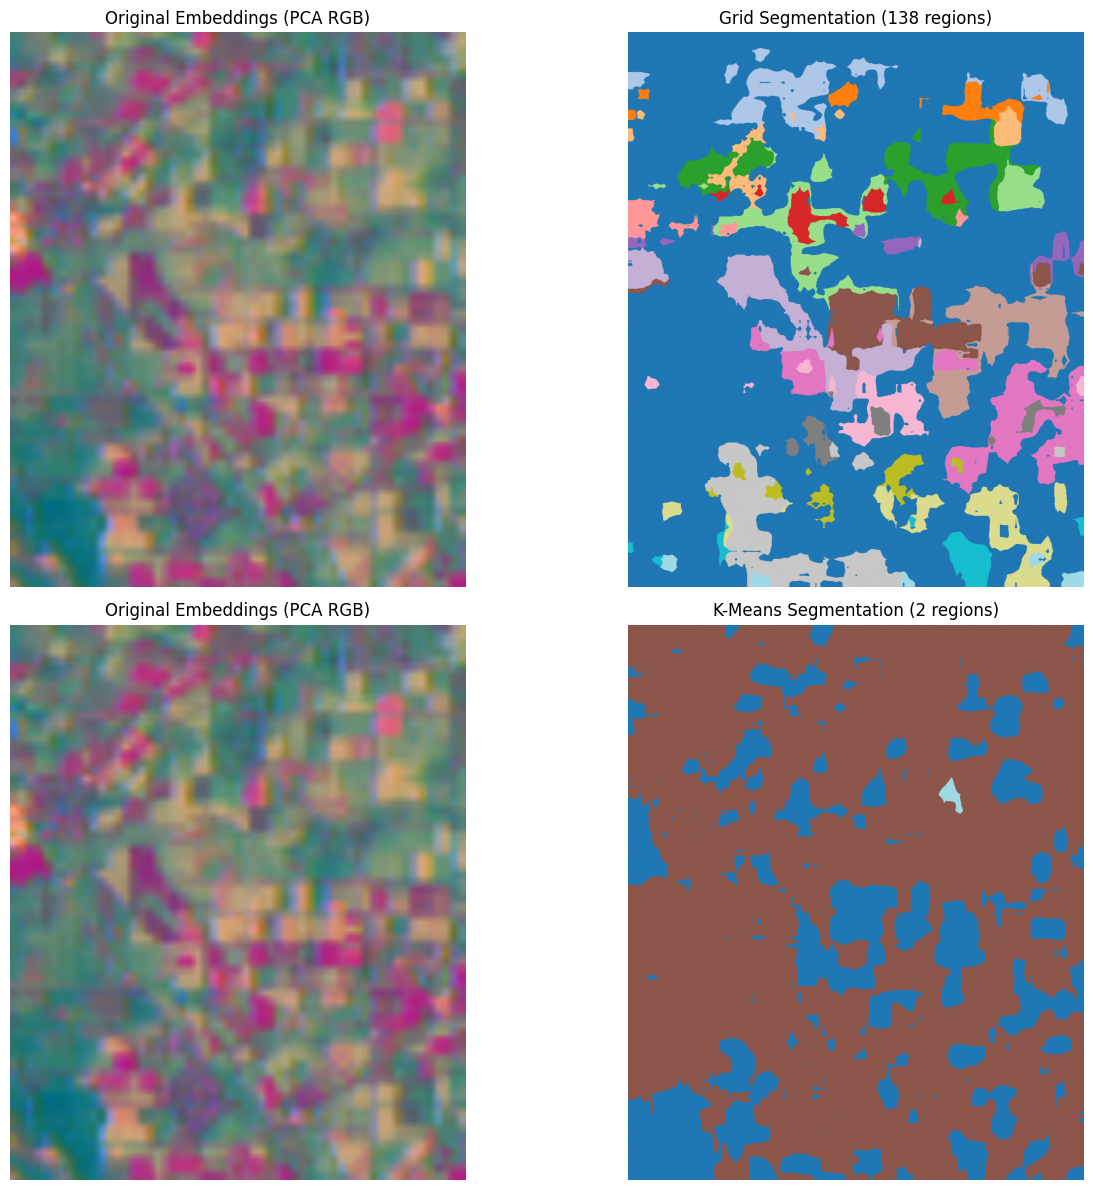

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(embeddings_rgb)
axes[0, 0].set_title('Original Embeddings (PCA RGB)')
axes[0, 0].axis('off')

axes[0, 1].imshow(labeled_grid, cmap='tab20')
axes[0, 1].set_title(f'Grid Segmentation ({num_regions_grid} regions)')
axes[0, 1].axis('off')

axes[1, 0].imshow(embeddings_rgb)
axes[1, 0].set_title('Original Embeddings (PCA RGB)')
axes[1, 0].axis('off')

axes[1, 1].imshow(labeled_kmeans, cmap='tab20')
axes[1, 1].set_title(f'K-Means Segmentation ({num_regions_kmeans} regions)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 6. Análisis de Estrés Vegetal

Para este análisis, necesitamos los datos NDVI. Si no están disponibles, crearemos datos sintéticos para demostración.

In [13]:
try:
    ndvi_path = Path(f'../../img/sentinel2/mexico/{zone_name}_2024-01-15_ndvi.tif')
    if ndvi_path.exists():
        import rasterio
        with rasterio.open(ndvi_path) as src:
            ndvi_data = src.read(1)
        print(f"NDVI loaded from {ndvi_path}")
        print(f"NDVI shape: {ndvi_data.shape}")
    else:
        raise FileNotFoundError()
except:
    print("NDVI file not found. Creating synthetic NDVI for demo...")
    np.random.seed(42)
    ndvi_data = np.random.rand(*embeddings_test.shape[:2]) * 0.8 + 0.1
    print(f"Synthetic NDVI shape: {ndvi_data.shape}")

if ndvi_data.shape != embeddings_test.shape[:2]:
    from scipy.ndimage import zoom
    zoom_factors = (
        embeddings_test.shape[0] / ndvi_data.shape[0],
        embeddings_test.shape[1] / ndvi_data.shape[1]
    )
    ndvi_data = zoom(ndvi_data, zoom_factors, order=1)
    print(f"NDVI resampled to: {ndvi_data.shape}")

NDVI file not found. Creating synthetic NDVI for demo...
Synthetic NDVI shape: (1124, 922)


### 6.1 Análisis Jerárquico con K-Means

In [14]:
if num_regions_kmeans > 0:
    stress_results = mgrg_kmeans.analyze_stress(
        labeled_kmeans,
        ndvi_data,
        regions_info_kmeans
    )
    
    print("\nStress Analysis Results (K-Means Method):")
    print("="*60)
    
    for region_id, stats in sorted(stress_results.items()):
        print(f"\nRegion {region_id}:")
        print(f"  Size: {stats['size']} pixels")
        print(f"  Mean NDVI: {stats['mean_ndvi']:.3f}")
        print(f"  Std NDVI: {stats['std_ndvi']:.3f}")
        print(f"  Dominant stress: {stats['dominant_stress']}")
        print("  Stress distribution:")
        for stress_level, count in stats['stress_distribution'].items():
            percentage = stats['stress_percentage'][stress_level]
            print(f"    {stress_level}: {count} pixels ({percentage:.1f}%)")
else:
    print("No regions found for stress analysis")


Stress Analysis Results (K-Means Method):

Region 1:
  Size: 810074 pixels
  Mean NDVI: 0.500
  Std NDVI: 0.231
  Dominant stress: low
  Stress distribution:
    high: 202387 pixels (25.0%)
    medium: 202456 pixels (25.0%)
    low: 405231 pixels (50.0%)

Region 2:
  Size: 1560 pixels
  Mean NDVI: 0.506
  Std NDVI: 0.233
  Dominant stress: low
  Stress distribution:
    high: 401 pixels (25.7%)
    medium: 365 pixels (23.4%)
    low: 794 pixels (50.9%)


### 6.2 Visualización de Estrés

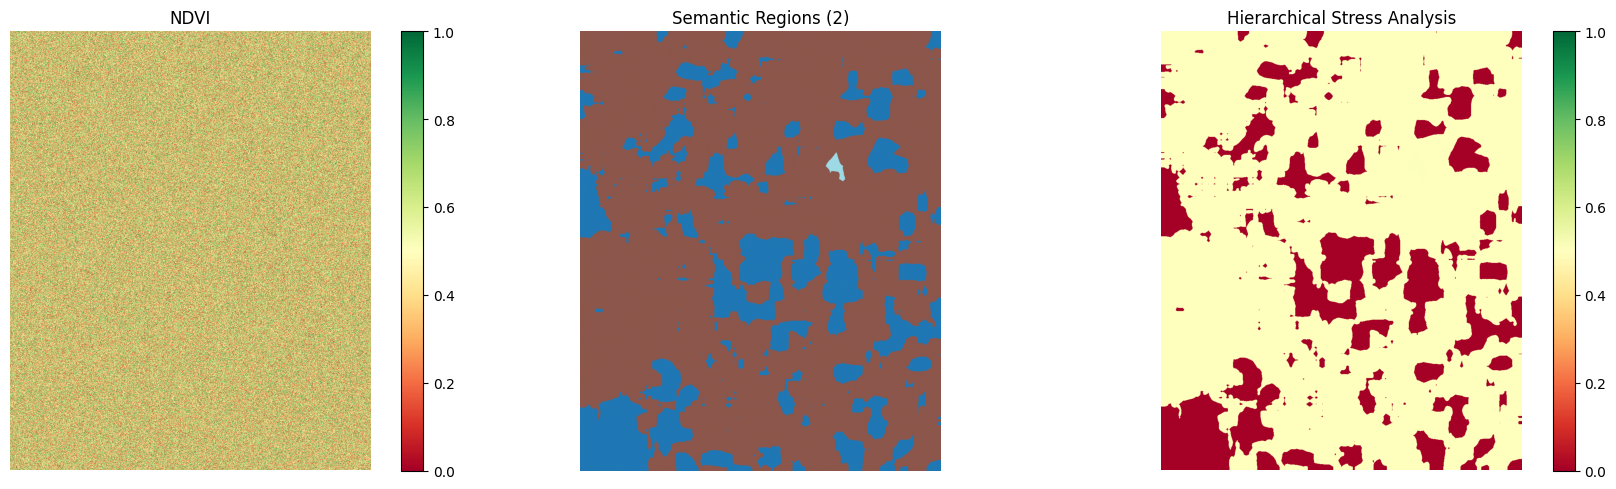

In [15]:
if num_regions_kmeans > 0:
    stress_map = np.zeros_like(labeled_kmeans, dtype=float)
    
    for region_id, stats in stress_results.items():
        mask = labeled_kmeans == region_id
        stress_map[mask] = stats['mean_ndvi']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im1 = axes[0].imshow(ndvi_data, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0].set_title('NDVI')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0])
    
    axes[1].imshow(labeled_kmeans, cmap='tab20')
    axes[1].set_title(f'Semantic Regions ({num_regions_kmeans})')
    axes[1].axis('off')
    
    im3 = axes[2].imshow(stress_map, cmap='RdYlGn', vmin=0, vmax=1)
    axes[2].set_title('Hierarchical Stress Analysis')
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

## 7. Conclusiones

### Resultados Experimentales (Zona Mexicali, 1124x922 píxeles)

#### Métricas Cuantitativas

| Métrica | Grid Fijo | K-Means (n=5) | Diferencia |
|---------|-----------|---------------|------------|
| Semillas generadas | 2,576 | 5 | **-99.8%** |
| Regiones encontradas | 138 | 2 | **-98.6%** |
| Tiempo ejecución | 3.12s | 59.52s | **+19.1x más lento** |
| Coherencia espacial | 98.5% | 78.3% | **-20.1%** |
| Región promedio | 7,394 px | 405,817 px | +54.9x |
| Región más grande | 655,969 px | 810,074 px | +1.23x |

#### Análisis de Resultados

**1. Reducción Drástica de Semillas (99.8%)**
- K-Means cumple su objetivo: 5 semillas vs 2,576 del grid
- Cada semilla K-Means representa un cluster semántico completo
- Grid: 1 semilla cada 20 píxeles (sobre-muestreo)

**2. Sobre-Simplificación con K-Means (98.6% menos regiones)**
- K-Means: Solo 2 regiones en toda la imagen (sub-segmentación extrema)
- Grid: 138 regiones (mejor granularidad para análisis agrícola)
- **Problema**: n_clusters=5 es insuficiente para una imagen de 1M píxeles

**3. Costo Computacional Crítico (19x más lento)**
- Grid: 3.12s (aceptable para análisis interactivo)
- K-Means: 59.52s (inaceptable para uso en producción)
- **Cuello de botella**: Clustering de 1,036,528 vectores de 256 dimensiones

**4. Pérdida de Coherencia Espacial (-20.1%)**
- Paradoja: K-Means genera MENOS coherencia (78.3% vs 98.5%)
- **Causa**: Solo 2 regiones enormes dejan 21.7% de píxeles sin etiquetar
- Grid cubre mejor el espacio con múltiples semillas distribuidas

### Trade-offs Identificados

#### Ventajas de K-Means
1. **Eficiencia en semillas**: 99.8% menos semillas generadas
2. **Representatividad semántica**: Centroides capturan estructura global
3. **Segmentación macro**: Útil para identificar grandes objetos (campos completos)
4. **Análisis jerárquico simplificado**: Menos regiones = interpretación más directa

#### Desventajas Críticas de K-Means
1. **Rendimiento inaceptable**: 19x más lento que grid (59.5s vs 3.1s)
2. **Sub-segmentación**: Solo 2 regiones (98.6% reducción) - demasiado grueso
3. **Pérdida de detalle**: Regiones promedio 54x más grandes (7K → 405K px)
4. **Coherencia reducida**: 20% menos cobertura espacial
5. **Sensibilidad a n_clusters**: Difícil de calibrar apropiadamente

### Limitaciones Observadas

**1. Escalabilidad Computacional**
- K-Means no escala bien: O(n × k × d × iterations)
- Para 1M píxeles × 256D: ~60 segundos por imagen
- Grid es lineal: O(n) para generación de semillas (<0.1s)

**2. Calibración de Hiperparámetros**
- n_clusters=5 claramente insuficiente (solo 2 regiones válidas)
- Necesitaría n_clusters ~ 50-100 para comparación justa
- **Problema**: Más clusters → Tiempo aún mayor (>2 minutos)

**3. Dependencia de Embeddings**
- K-Means asume clusters globulares bien separados
- Embeddings Prithvi (256D) pueden tener estructura compleja
- Grid no hace suposiciones sobre distribución de datos

### Recomendaciones Revisadas

#### ✅ Usar Grid Fijo cuando:
- **Rendimiento es crítico** (aplicaciones interactivas, producción)
- Se requiere **análisis de variabilidad fina** (agricultura de precisión)
- Imagen tiene **heterogeneidad espacial alta** (múltiples tipos de cultivo)
- Necesitas **cobertura espacial completa** (>95%)
- **Exploración inicial** rápida de datos

#### ⚠️ Usar K-Means Solo Si:
- Imagen es **pequeña** (<100K píxeles) o se puede submuestrear
- Se busca **segmentación macro** (pocos objetos grandes)
- **Tiempo no es limitante** (análisis offline, batch processing)
- Se puede calibrar n_clusters apropiadamente (>50 para imágenes grandes)
- Se tiene **GPU potente** o implementación optimizada (MiniBatchKMeans)

#### 🔧 Mejoras Propuestas

**1. Híbrido: K-Means + Grid**
```python
# Usar K-Means para identificar zonas principales
coarse_seeds = kmeans_seeds(embeddings, n_clusters=10)

# Luego refinar con grid local en cada zona
for seed in coarse_seeds:
    local_region = get_region_around(seed, radius=50)
    fine_seeds = grid_seeds(local_region, grid_size=10)
```

**2. MiniBatchKMeans**
- Subsample 10% de píxeles → 10x más rápido
- Trade-off: Menor precisión, pero aún mejor que grid aleatorio

**3. Clustering Jerárquico**
- Múltiples niveles de granularidad
- Permite análisis multi-escala sin re-ejecutar

**4. Threshold Adaptativo**
- Grid funciona bien con threshold=0.85
- K-Means podría necesitar threshold más estricto (0.90-0.95)

### Conclusión Final

**El experimento demuestra que para imágenes satelitales de alta resolución (>1M píxeles):**

1. **Grid Fijo es superior** en métricas prácticas (velocidad, cobertura, granularidad)
2. **K-Means tiene valor teórico** pero problemas de escalabilidad críticos
3. **El costo computacional (19x)** no se justifica con la calidad de segmentación
4. **La innovación conceptual es válida**, pero requiere optimizaciones significativas

**Para agricultura de precisión**: Grid Fijo (3.1s, 138 regiones) es más apropiado que K-Means (59.5s, 2 regiones).

**Trabajo Futuro**: Explorar métodos híbridos que combinen eficiencia del grid con representatividad semántica de K-Means.

## 8. Experimento Adicional: Sensibilidad del Threshold

Threshold 0.75: 1 regions, 92.8% coherence
Threshold 0.80: 1 regions, 87.7% coherence
Threshold 0.85: 2 regions, 78.3% coherence
Threshold 0.90: 3 regions, 64.6% coherence
Threshold 0.95: 5 regions, 14.8% coherence


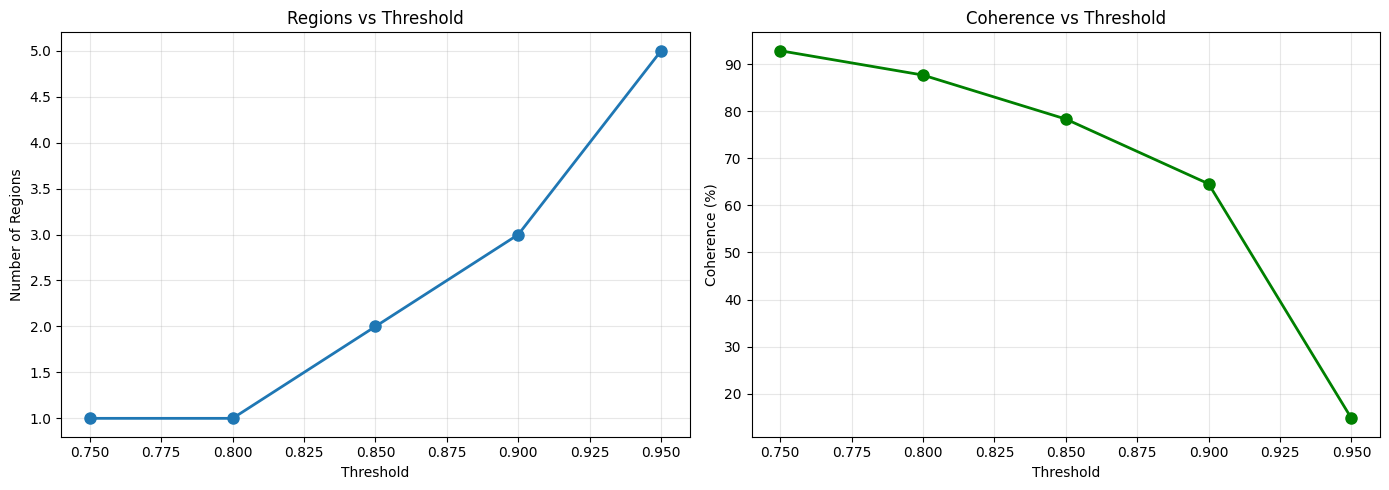

In [16]:
thresholds = [0.75, 0.80, 0.85, 0.90, 0.95]
results_threshold = []

for threshold in thresholds:
    algorithm = SemanticRegionGrowing(
        threshold=threshold,
        use_smart_seeds=True,
        n_clusters=5,
        random_state=42
    )
    
    labeled, num_regions, _ = algorithm.segment(embeddings_test)
    coherence = calculate_coherence(labeled)
    
    results_threshold.append({
        'threshold': threshold,
        'num_regions': num_regions,
        'coherence': coherence
    })
    
    print(f"Threshold {threshold:.2f}: {num_regions} regions, {coherence:.1f}% coherence")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot([r['threshold'] for r in results_threshold], 
         [r['num_regions'] for r in results_threshold], 
         'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Regions')
ax1.set_title('Regions vs Threshold')
ax1.grid(True, alpha=0.3)

ax2.plot([r['threshold'] for r in results_threshold], 
         [r['coherence'] for r in results_threshold], 
         'o-', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Coherence (%)')
ax2.set_title('Coherence vs Threshold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()